In [ ]:
# this package requires numpy version 1.23.5!!!

# !pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 79.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
bigframes 2.8.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which

In [8]:
import sys
print(f"Python version: {sys.version}")
from pathlib import Path
import gym
print(f"gym Version: {gym.__version__}")
from gym.wrappers import RecordVideo
import numpy as np
print(f"numpy Version: {np.__version__}")
import matplotlib.pyplot as plt
from collections import defaultdict
import random

from IPython.display import Video, display
import glob
import os


Python version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
gym Version: 0.25.2
numpy Version: 1.23.5


In [9]:
# 🧠 Set action space and Q-table shape
n_actions = gym.make("CartPole-v1").action_space.n
Q = defaultdict(lambda: np.zeros(n_actions))

# 🧮 Discretization setup (based on known CartPole space)
n_bins = (24, 24, 24, 24)  # bins for each state variable

# CartPole-v1 state space boundaries
obs_space_low = np.array([-4.8, -5.0, -0.418, -5.0])
obs_space_high = np.array([4.8, 5.0, 0.418, 5.0])

def discretize(obs):
    ratios = [(obs[i] - obs_space_low[i]) / (obs_space_high[i] - obs_space_low[i]) for i in range(len(obs))]
    new_obs = [int(np.floor(ratios[i] * n_bins[i])) for i in range(len(obs))]
    new_obs = [min(n_bins[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
    return tuple(new_obs)

In [ ]:
# 🎥 Recording configuration
recording_enabled = True       # 🔁 Set to False to disable all video recording
record_from_episode = 99999999     # Video Recording Broken
record_every_n_episodes = 100 # 🔂 Record every N episodes

# 📁 Save videos in a "videos" folder one level above the notebook
video_dir = (Path().resolve().parent / "videos").resolve()
video_dir.mkdir(parents=True, exist_ok=True)

def make_env_with_optional_recording(episode_num):
    """
    Creates CartPole-v1 environment, optionally wrapped with RecordVideo.
    Recording only occurs if enabled and episode_num matches conditions.
    """
    if recording_enabled and episode_num >= record_from_episode and \
       (episode_num - record_from_episode) % record_every_n_episodes == 0:
        env = gym.make("CartPole-v1", render_mode="rgb_array")
        env = RecordVideo(
            env,
            video_folder=str(video_dir),
            episode_trigger=lambda e: True,
            name_prefix=f"cartpole_ep{episode_num}"
        )
        print(f"[🎥] Recording episode {episode_num} to {video_dir}")
    else:
        env = gym.make("CartPole-v1")
    return env

In [14]:
# Q-learning hyperparameters
alpha = 0.1       # learning rate
gamma = 0.99       # discount factor
epsilon = 1.0      # exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
n_episodes = 500

In [15]:
rewards_per_episode = []

# Q-learning loop
for episode in range(n_episodes):
    env = make_env_with_optional_recording(episode)  # ⬅️ create env per episode
    obs = env.reset()
    state = discretize(obs[0] if isinstance(obs, tuple) else obs)
    total_reward = 0

    done = False
    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        next_obs, reward, done, _, = env.step(action)
        next_state = discretize(next_obs)
        total_reward += reward

        # Update Q-value
        best_next_action = np.argmax(Q[next_state])
        td_target = reward + gamma * Q[next_state][best_next_action]
        td_delta = td_target - Q[state][action]
        Q[state][action] += alpha * td_delta

        state = next_state

    env.close()  # ✅ close per-episode env, especially for video encoding

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_per_episode.append(total_reward)

    if (episode + 1) % (n_episodes // 10) == 0:
        print(f"Episode {episode + 1}: reward={total_reward}, epsilon={epsilon:.3f}")


Episode 50: reward=14.0, epsilon=0.778
Episode 100: reward=25.0, epsilon=0.606
Episode 150: reward=93.0, epsilon=0.471
Episode 200: reward=114.0, epsilon=0.367
[🎥] Recording episode 200 to D:\Ufunta'ar Alavia\rl-qlearn-cartpole\videos


DependencyNotInstalled: pygame is not installed, run `pip install gym[classic_control]`

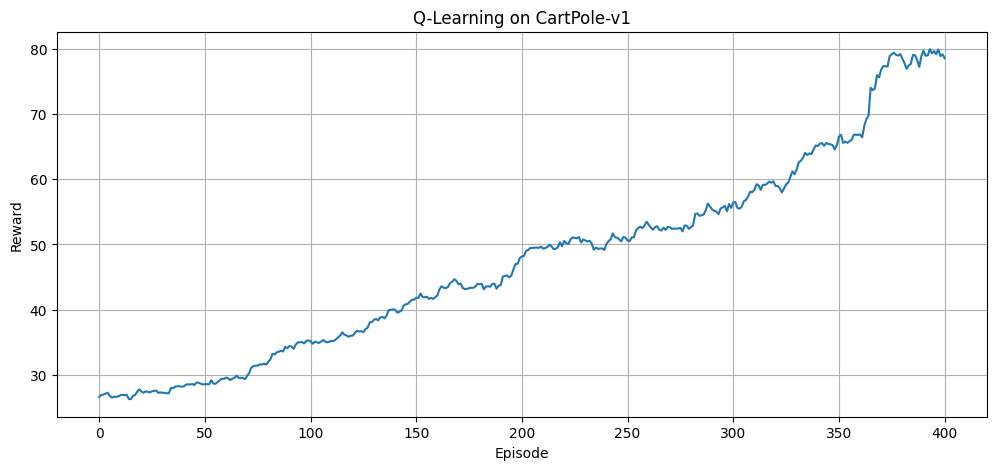

In [28]:
# Plot training performance
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 5))
plt.plot(moving_average(rewards_per_episode, 100))
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Q-Learning on CartPole-v1")
plt.grid(True)
plt.show()

In [3]:
# Find the most recent video file in the video directory
video_files = glob.glob(str(video_dir / "*.mp4"))
if not video_files:
    print("No videos found in", video_dir)
else:
    latest_video = max(video_files, key=os.path.getctime)
    print(f"Displaying video: {os.path.basename(latest_video)}")
    display(Video(latest_video, embed=True, width=600))

NameError: name 'video_dir' is not defined